#  Ebnable HTML/CSS 
from IPython.core.display import HTML
HTML("<link href='https://fonts.googleapis.com/css?family=Passion+One' rel='stylesheet' type='text/css'><style>div.attn { font-family: 'Helvetica Neue'; font-size: 30px; line-height: 40px; color: #FFFFFF; text-align: center; margin: 30px 0; border-width: 10px 0; border-style: solid; border-color: #5AAAAA; padding: 30px 0; background-color: #DDDDFF; }hr { border: 0; background-color: #ffffff; border-top: 1px solid black; }hr.major { border-top: 10px solid #5AAA5A; }hr.minor { border: none; background-color: #ffffff; border-top: 5px dotted #CC3333; }div.bubble { width: 65%; padding: 20px; background: #DDDDDD; border-radius: 15px; margin: 0 auto; font-style: italic; color: #f00; }em { color: #AAA; }div.c1{visibility:hidden;margin:0;height:0;}div.note{color:red;} th {text-align:center;}</style>")

# Contraceptive Method Choice
Lab Assignment Five: Evaluation and Multi-Layer Perceptron

**_Jake Oien, Seung Ki Lee, Jenn Le_**

## Data Preparation and Overview

### Class Variables

Dataset Source: https://archive.ics.uci.edu/ml/datasets/Contraceptive+Method+Choice

This dataset is a subset of the 1987 National Indonesia Contraceptive Prevalence Survey. The samples are married women who were either not pregnant or do not know if they were at the time of interview. The problem is to predict the current contraceptive method choice (no use, long-term methods, or short-term methods) of a woman based on her demographic and socio-economic characteristics.

1. Wife's age (numerical) 
2. Wife's education (categorical) 1=low, 2, 3, 4=high 
3. Husband's education (categorical) 1=low, 2, 3, 4=high 
4. Number of children ever born (numerical) 
5. Wife's religion (binary) 0=Non-Islam, 1=Islam 
6. Wife's now working? (binary) 0=Yes, 1=No 
7. Husband's occupation (categorical) 1, 2, 3, 4 
8. Standard-of-living index (categorical) 1=low, 2, 3, 4=high 
9. Media exposure (binary) 0=Good, 1=Not good 
10. Contraceptive method used (class attribute) 1=No-use, 2=Long-term, 3=Short-term
### Business Case

For the purposes of this report, and our understanding of the dataset, we will define the three classifiers here. We will assume 0/No-use of contraceptives means that the woman is not currently using contraceptives. 1/Short-term use is contraceptives with a short-term duration (such as the pill). We assume 2/long-term contraceptives are those that can last a much longer period of time than short-term method, so ones that can years or are permanent. 

It is likely that this data will not be able to achieve a high level of accuracy on classification, given that 8 features would not intuitively seem to be able to predict a woman’s contraceptive use. That is a quite complicated social issue. 

However, some level of prediction beyond random chance might be used as a weight in some ad targeting platform. Given some set of data about a woman, a company that specializes in contraceptives may want to target an ad toward that woman. If with some level of confidence beyond random guessing a model is able to predict that a woman is using short term contraceptives, the company that makes the contraceptives might target that woman/her demographic with ads as opposed to another demographic, in order to take the competition from other short term contraceptive companies.

 If a woman is predicted to be using long-term contraceptives, the company might not target ads at her, because a short-term contraceptive would be useless. Also, if a woman is not predicted to be using contraceptives, analysis of her data might conclude that she is not only using contraceptives right now, but in the future will also not use contraceptives. An ad would not be a good use of money there. 

Something that might indicate success of the model is if it can achieve a rate of success that is simply reasonably better than random chance. The better the overall accuracy score, the more confident an advertiser might feel about using it in an ad targeting platform. Again, the accuracy score would not be used as a end-all be-all prediction, but might be used as a weight in whether or not to include a given woman in the target audience for a contraceptive product. 

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Here, we'll import the data and add column names
col_names = ["wife_age", 
             "wife_education", 
             "husband_education", 
             "num_children", 
             "wife_practices_islam", 
             "wife_working", 
             "husband_occupation",
             "sol_index",  # standard of living index
             "media_exposure",
             "contraceptive_method"
            ]
data = pd.read_csv("./cmc.csv", header=None, names=col_names, encoding='latin-1')

In [3]:
data.info()
data.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1473 entries, 0 to 1472
Data columns (total 10 columns):
wife_age                1473 non-null int64
wife_education          1473 non-null int64
husband_education       1473 non-null int64
num_children            1473 non-null int64
wife_practices_islam    1473 non-null int64
wife_working            1473 non-null int64
husband_occupation      1473 non-null int64
sol_index               1473 non-null int64
media_exposure          1473 non-null int64
contraceptive_method    1473 non-null int64
dtypes: int64(10)
memory usage: 115.2 KB


,wife_age,wife_education,husband_education,num_children,wife_practices_islam,wife_working,husband_occupation,sol_index,media_exposure,contraceptive_method
0,24,2,3,3,1,1,2,3,0,1
1,45,1,3,10,1,1,3,4,0,1
2,43,2,3,7,1,1,3,4,0,1
3,42,3,2,9,1,1,3,3,0,1
4,36,3,3,8,1,1,3,2,0,1
5,19,4,4,0,1,1,3,3,0,1
6,38,2,3,6,1,1,3,2,0,1
7,21,3,3,1,1,0,3,2,0,1
8,27,2,3,3,1,1,3,4,0,1
9,45,1,1,8,1,1,2,2,1,1


First, all of the data exists; there are no non-null values. 

Second, the `husband_occupation` field does not have a good description for the data. The only information about it is that it is a categorical field that can contain the values 1,2,3,4. Without more information, we will remove `husband_occupation` from the dataset. 

Third, the `wife_working` field has some non-intuitive inverted logic in it. In the dataset given, a 0 means working and a 1 means not working. We will flip those around so that now the dataset means that a 1 means working and a 0 means not working. Similarly, the `media_exposure` column uses a 0 to mean "Good" and a 1 to mean "Not good". We will also flip those values so that the lower number refers to a worse category. Also, the wife_working column has the same issue. 0 means working but we will make it mean not working. 

Finally, because our classifier doesn't really make sense since 'long-term' comes between 'no use' and 'short-term' therefore we'll change the values for 'no use', 'short-term', and 'long-term' to be 0, 1, and 2 respectively. 

In [4]:
# remove husband_occupation
if "husband_occupation" in data:
    del data["husband_occupation"]
    
# flip 1s and 0s    1-1 = 0, 1-0 = 1
data["wife_working"] = 1-data["wife_working"]
data["media_exposure"] = 1-data["media_exposure"]

# replacing contraceptive method
data['contraceptive_method'].replace(to_replace=[1, 3, 2],
                        value=[0, 1, 2], inplace = True)
data.head()

,wife_age,wife_education,husband_education,num_children,wife_practices_islam,wife_working,sol_index,media_exposure,contraceptive_method
0,24,2,3,3,1,0,3,1,0
1,45,1,3,10,1,0,4,1,0
2,43,2,3,7,1,0,4,1,0
3,42,3,2,9,1,0,3,1,0
4,36,3,3,8,1,0,2,1,0


There are a few things we can look at regarding this data. To start, let's look at the class distribution. 

Class Distribution
contraceptive_method
0    629
1    511
2    333
Name: num_children, dtype: int64


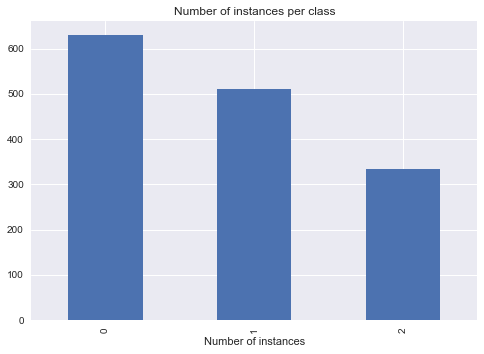

In [5]:
%matplotlib inline
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter('ignore', DeprecationWarning)

data_grouped_by_contraceptive_method = data.groupby(by=["contraceptive_method"])

print("Class Distribution")
print(data_grouped_by_contraceptive_method.num_children.count())
data_grouped_by_contraceptive_method.num_children.count().plot(kind='bar')
plt.xlabel("Number of instances")
plt.title("Number of instances per class")
plt.show()

Let's take a look at contraceptive use vs the number of children the wife has. 


Class Distribution Grouped by Number of Children
contraceptive_method    0    1   2
num_children                      
0                      95    2   0
1                     143   87  46
2                     114  106  56
3                      70  119  70
4                      57   78  62
5                      44   55  36
6                      35   30  27
7                      18   12  19
8                      29    9   9
9                       5    8   3
10                      9    0   2
11                      6    3   2
12                      4    0   0
13                      0    1   1
16                      0    1   0


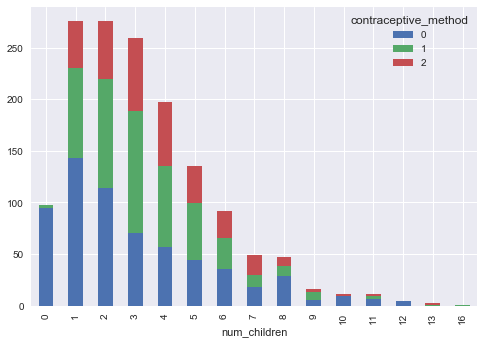

In [6]:
num_children_by_contraceptive_method = pd.crosstab([data["num_children"]], data.contraceptive_method)

print("\nClass Distribution Grouped by Number of Children")
print(num_children_by_contraceptive_method)

num_children_by_contraceptive_method.plot(kind="bar", stacked=True)

The majority of the woman surveyed have 5 or less children. Of note, 2 women had 16 children!

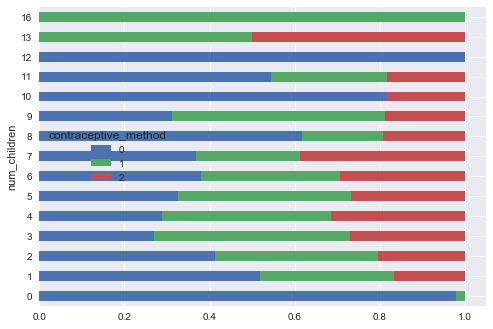

In [7]:
num_children_percentage = num_children_by_contraceptive_method.div(num_children_by_contraceptive_method.sum(axis=1).astype(float),
                             axis=0) # normalize the value

num_children_percentage.plot(kind="barh", stacked=True);

We can see that for wives with 0 children, contraceptive use is almost all "No use". As the number of children increases, we see that families with a smaller amount of children (1-3) start to increase in use of long-term contraceptive use. Similarly, after number of children gets to 3, short term contraceptive usage seems to increase in the percentage of the sampled population. 

One might think that contraceptive use would correspond with having less children, because women on birth control have less kids. However, contraceptive usage might actually be a response to family size. At a certain point, a family might decide their family is too big, and start using contraceptives to avoid their family getting larger. This is just one of many possible explanations for this dataset. 

Another point to take a look at is the use of contraceptives related to education levels and standards of living. According to the paper found here https://www.jstor.org/stable/2138087, women's contraceptive usage tends to increase as their level of education increases. Additionally, a lower standard of living might mean that a women has less access to contraceptives and hence would tend towards "No use". This dataset lines up with that research, but that observation should only be noted, rather be presented as a truth or proof of the research's validity. 

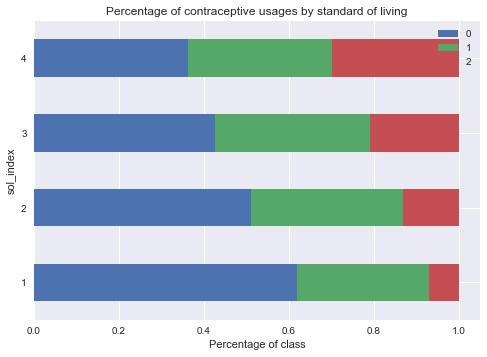

In [8]:
sol = pd.crosstab([data.sol_index], data.contraceptive_method)
# print (sol)
# sol_and_education.plot(kind="bar", stacked=True)

sol_percentage = sol.div(sol.sum(axis=1).astype(float),
                             axis=0) # normalize the value

sol_percentage.plot(kind="barh", stacked=True)
plt.title("Percentage of contraceptive usages by standard of living");
plt.xlabel("Percentage of class");
plt.legend();

One thing to note from the table here is the increase in number of women surveyed as their standard of living increases. We can see clearly from this graph that as the standard of living goes up, use of contraceptives goes up. Short term contraceptive use seems to stay constant, but long term contraceptive use goes up. 

Finally, let's look at education and contraceptive use. 

contraceptive_method    0    1    2
wife_education                     
1                     103   40    9
2                     176  121   37
3                     175  155   80
4                     175  195  207


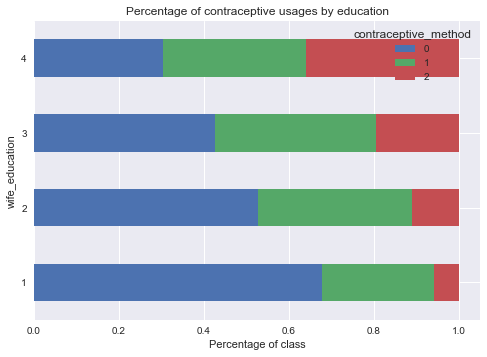

In [9]:
education = pd.crosstab([data.wife_education], data.contraceptive_method)
print (education)
# sol_and_education.plot(kind="bar", stacked=True)

education_percentage = education.div(education.sum(axis=1).astype(float),
                             axis=0) # normalize the value

education_percentage.plot(kind="barh", stacked=True)
plt.title("Percentage of contraceptive usages by education")
plt.xlabel("Percentage of class");

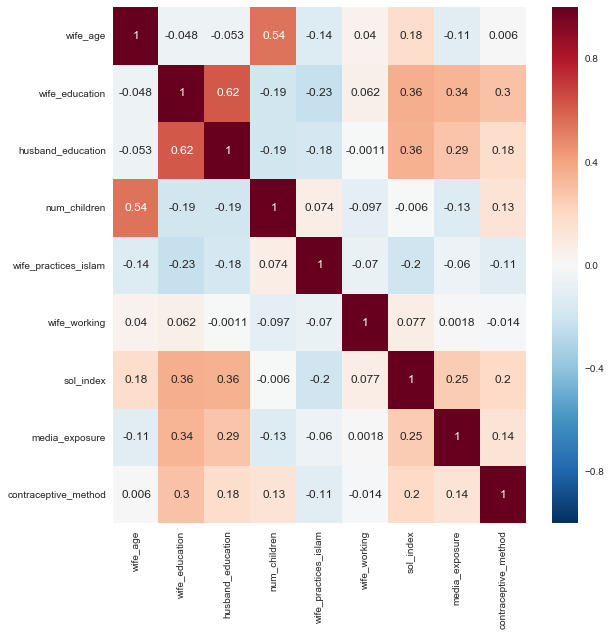

In [10]:
# plot the correlation matrix using seaborn
# cmap = sns.diverging_palette(220, 10, as_cmap=True) 
# sns.set(style="darkgrid") 

f, ax = plt.subplots(figsize=(9, 9))

sns.heatmap(data.corr(), annot=True, center=0)

f.tight_layout()

From this heatmap we see a few strong correlations. The strongest correlation is that between the husband's education and the wife's education. It would make sense that a couple would tend to have similar education levels, or at least that as one member of the couple trends towards higher education that the other would trend toward higher education. Of course, this cannot be generalized, this is merely the correlation that we are observing. 

Additionally, we see that the next highest correlation is that between wife_age and num_children. Younger women simply haven't had as much time as other women to have children, which might explain the strong correlation. 

Related to contraceptive method, we see that the strongest correlations are with the Standard of Living index, and husband/wife education. These are overall pretty weak correlations, but that doesn't mean that the data cannot be predicted. Correlation measurements measure a linear relationship between variables, and they might not actually have an underlying linear relationship.

## Data Evaluation

### Choose and Explain Metric to Evaluate Performance

Originally, when we worked with this dataset, we focused on overall accuracy as our measure of success. This is not necessarily what we want for our business case. 

As a reminder of our business case, we are trying to advertise our short-term contraceptive product to women. Our assumption is that it would be a waste of money to advertise the product to women who are using long-term contraceptives, as our product would not provide them with any value. 

We assume that a woman who is not currently using contraceptives and one who is using short-term contraceptives can be considered under the same advertising strategy, either because we would like to convince someone new to use our product, or because we think we can take business from another competing product.  Therefore, we will consider misclassifications of no-use/short-term use to be correct classifications of each other.

Additionally, if the actual class is a long-term user, we don't want to advertise our product to them becasue that would be a waste of money according to our assumption that they will not buy our product, so we consider misclassifications when the actual class is long-term use. 

When the actual class is a short-term user or no use, and we predict that they are a long term user, we will not be advertising to a potential buyer of our product. We would be losing out on potential business, so we will consider those misclassifications in our evaluation criteria.

Finally, intellectually, we would like to be able to say that we can classify everything properly, but for our business case, it does not matter to us if we can successfully classify long-term users. In fact, a lot of successful classifications of long-term users could bias our score and make us think we're doing better for our business case than we actually are. In order to keep our (admittedly generous measure) pessimistic, we do not include successful classifications of long term users in our evaluation criteria, in order to keep the focus of our evaluation on the cases that make or lose us money. Long term use is still included in the metric, but only on misclassifications, and successful classifications do not affect the metric. 

For our metric, we follow the same principle as the accuracy score metric, by summing up successful classifications and dividing that sum by the total number of instances considered.

The following table summarizes our evaluation criteria score measure: 
<table>
    <tbody>
    <tr>
        <th colspan="2" rowspan="2"></th>
        <th colspan="3">Predicted class</th>
    </tr>
    <tr>
        <th>No use</th>
        <th>Short-term use</th>
        <th>Long-term use</th>
    </tr>
    <tr>
        <th rowspan="3">Actual class</th>
        <th>No use</th>
        <td>1</td>
        <td>1</td>
        <td>0</td>
    </tr>
    <tr>
        <th>Short-term use</th>
        <td>1</td>
        <td>1</td>
        <td>0</td>
    </tr>
    <tr>
        <th>Long-term use</th>
        <td>0</td>
        <td>0</td>
        <td>N/A</td>
    </tr>
    </tbody>
</table>

For reference, here is a table for the accuracy_score in the same format:

<table>
    <tbody>
    <tr>
        <th colspan="2" rowspan="2"></th>
        <th colspan="3">Predicted class</th>
    </tr>
    <tr>
        <th>No use</th>
        <th>Short-term use</th>
        <th>Long-term use</th>
    </tr>
    <tr>
        <th rowspan="3">Actual class</th>
        <th>No use</th>
        <td>1</td>
        <td>0</td>
        <td>0</td>
    </tr>
    <tr>
        <th>Short-term use</th>
        <td>0</td>
        <td>1</td>
        <td>0</td>
    </tr>
    <tr>
        <th>Long-term use</th>
        <td>0</td>
        <td>0</td>
        <td>1</td>
    </tr>
    </tbody>
</table>

What our score does is turns the scoring into a binary scoring problem, as No-use and short-term use can be considered to be the same for the intents of the scoring function. With more domain knowledge, a more sophisticated scoring function could be used that assigns different costs to the different misclassifications. For example, our assumption that No-use and Short-term use are the same might be somewhat correct, but maybe it turns out that a slightly different advertising campaign targeted at the two classes might be more financially lucrative. 

When tuning a model based on maximizing our score, it seems that the scoring metric could bias the model towards predicting No-use and Short-term use, because the model receives no benefit to its score from classifying an instance as Long-term usage. If this turns out to be the case, a different evaluation criterion should be used. One thing that should be given a look as a sniff test is to look at the micro precision of the Long-term use class. If as the model is tuned the micro-precision score goes down as our custom metric goes up, then we might be seeing the effects of tending to classify everything as No-use or Short-term use. We could also look at the accuracy of the model's predictions to achieve a similar effect. 

____
Finally, here is the implementation of our score and an example of it. 

### Method for Dividing and Testing Dataset

For dividing and testing our dataset, we will use 10-fold cross validation. We considered using stratified k-fold cross validation, but this is why we didn't ultimately go with that route. 

The reasoning for using stratified cross validation would be to ensure that a fold contains enough members of an underbalanced class to sufficiently train that fold's model. We do not have a huge class imbalance, so that problem is not relevant. 

Additionally, another reason to stratify testing sets is to preserve some ratio of classes. We are unable to say for certain if the ratio of our classes is indicative of that of the population, firstly because we did not do the data collection ourself and secondly because we do not have the data for the full population. We cannot be certain that a new batch of women's data coming in will have that same class ratio, and so we do not want to introduce any sort of bias that a stratified method might cause. 

## Modeling

### Custom Implementation of Multi-Layer Perceptron

In [11]:
# Example adapted from https://github.com/rasbt/python-machine-learning-book/blob/master/code/ch12/ch12.ipynb
# Original Author: Sebastian Raschka
# This is the optional book we use in the course, excellent intuitions and straightforward programming examples
# please note, however, that this code has been manipulated to reflect our assumptions and notation.
import numpy as np
from scipy.special import expit
import pandas as pd
import sys

# start with a simple base classifier, which can't be fit or predicted
# it only has internal classes to be used by classes that will subclass it
class TwoLayerPerceptronBase(object):
    def __init__(self, n_hidden=30,
                 C=0.0, epochs=500, eta=0.001, random_state=None):
        np.random.seed(random_state)
        self.n_hidden = n_hidden
        self.l2_C = C
        self.epochs = epochs
        self.eta = eta
        
    @staticmethod
    def _encode_labels(y):
        """Encode labels into one-hot representation"""
        onehot = pd.get_dummies(y).values.T
            
        return onehot
    
    def _initialize_weights(self):
        """Initialize weights with small random numbers."""
        W1_num_elems = (self.n_features_ + 1)*self.n_hidden
        W1 = np.random.uniform(-1.0, 1.0,size=W1_num_elems)
        W1 = W1.reshape(self.n_hidden, self.n_features_ + 1) # reshape to be W
        
        W2_num_elems = (self.n_hidden + 1)*self.n_output_
        W2 = np.random.uniform(-1.0, 1.0, size=W2_num_elems)
        W2 = W2.reshape(self.n_output_, self.n_hidden + 1)
        return W1, W2
    
    @staticmethod
    def _sigmoid(z):
        """Use scipy.special.expit to avoid overflow"""
        # 1.0 / (1.0 + np.exp(-z))
        return expit(z)
    
    @staticmethod
    def _relu(Z):
        return np.maximum(0,Z.copy())    
    
    @staticmethod
    def _add_bias_unit(X, how='column'):
        """Add bias unit (column or row of 1s) to array at index 0"""
        if how == 'column':
            ones = np.ones((X.shape[0], 1))
            X_new = np.hstack((ones, X))
        elif how == 'row':
            ones = np.ones((1, X.shape[1]))
            X_new = np.vstack((ones, X))
        return X_new
    
    @staticmethod
    def _L2_reg(lambda_, W1, W2):
        """Compute L2-regularization cost"""
        # only compute for non-bias terms
        return (lambda_/2.0) * np.sqrt(np.mean(W1[:, 1:] ** 2) + np.mean(W2[:, 1:] ** 2))
    
    def _cost(self,A3,Y_enc,W1,W2):
        '''Get the objective function value'''
        cost = np.mean((Y_enc-A3)**2)
        L2_term = self._L2_reg(self.l2_C, W1, W2)
        return cost + L2_term
    
    def _feedforward(self, X, W1, W2):
        """Compute feedforward step
        """
        A1 = self._add_bias_unit(X, how='column')
        Z1 = W1 @ A1.T
        A2 = self._sigmoid(Z1)
        A2 = self._add_bias_unit(A2, how='row')
        Z2 = W2 @ A2
        A3 = self._sigmoid(Z2)
        return A1, Z1, A2, Z2, A3
    
    def _get_gradient(self, A1, A2, A3, Z1, Z2, Y_enc, W1, W2):
        """ Compute gradient step using backpropagation.
        """
        # vectorized backpropagation
        sigma3 = -2*(Y_enc-A3)*A3*(1-A3)
        sigma2 = (W2.T @ sigma3)*A2*(1-A2)
        
        grad1 = sigma2[1:,:] @ A1
        grad2 = sigma3 @ A2.T
        
        # regularize weights that are not bias terms
        grad1[:, 1:] += W1[:, 1:] * self.l2_C
        grad2[:, 1:] += W2[:, 1:] * self.l2_C

        return grad1, grad2
    
    def predict(self, X):
        """Predict class labels"""
        _, _, _, _, A3 = self._feedforward(X, self.W1, self.W2)
        y_pred = np.argmax(A3, axis=0)
        return y_pred

MiniBatching

In [12]:
# from sklearn.metrics import accuracy_score -> use custom
# just start with the vectorized version and minibatch
class TLPMiniBatch(TwoLayerPerceptronBase):
    def __init__(self, alpha=0.0, decrease_const=0.0, shuffle=True, 
                 minibatches=1, **kwds):        
        # need to add to the original initializer 
        self.alpha = alpha
        self.decrease_const = decrease_const
        self.shuffle = shuffle
        self.minibatches = minibatches
        # but keep other keywords
        super().__init__(**kwds)
   
    
    def fit(self, X, y, print_progress=False):
        """ Learn weights from training data. With mini-batch"""
        X_data, y_data = X.copy(), y.copy()
        Y_enc = self._encode_labels(y)
        
        # init weights and setup matrices
        self.n_features_ = X_data.shape[1]
        self.n_output_ = Y_enc.shape[0]
        self.W1, self.W2 = self._initialize_weights()

        delta_W1_prev = np.zeros(self.W1.shape)
        delta_W2_prev = np.zeros(self.W2.shape)

        self.cost_ = []
        self.score_ = []
        for i in range(self.epochs):

            # adaptive learning rate
            self.eta /= (1 + self.decrease_const*i)
            
            if print_progress>0 and (i+1)%print_progress==0:
                sys.stderr.write('\rEpoch: %d/%d' % (i+1, self.epochs))
                sys.stderr.flush()

            if self.shuffle:
                idx_shuffle = np.random.permutation(y_data.shape[0])
                X_data, Y_enc, y_data = X_data[idx_shuffle], Y_enc[:, idx_shuffle], y_data[idx_shuffle]

            mini = np.array_split(range(y_data.shape[0]), self.minibatches)
            mini_cost = []
            for idx in mini:

                # feedforward
                A1, Z1, A2, Z2, A3 = self._feedforward(X_data[idx],
                                                       self.W1,
                                                       self.W2)
                
                cost = self._cost(A3,Y_enc[:, idx],self.W1,self.W2)
                mini_cost.append(cost) # this appends cost of mini-batch only

                # compute gradient via backpropagation
                grad1, grad2 = self._get_gradient(A1=A1, A2=A2, A3=A3, Z1=Z1, Z2=Z2, 
                                                  Y_enc=Y_enc[:, idx],
                                                  W1=self.W1,W2=self.W2)

                # momentum calculations
                delta_W1, delta_W2 = self.eta * grad1, self.eta * grad2
                self.W1 -= (delta_W1 + (self.alpha * delta_W1_prev))
                self.W2 -= (delta_W2 + (self.alpha * delta_W2_prev))
                delta_W1_prev, delta_W2_prev = delta_W1, delta_W2

            self.cost_.append(mini_cost)
            self.score_.append(custom_score(y_data,self.predict(X_data)))
            
        return self
    
    
    

And now, finally our Custom Two Layered Perceptron

In [13]:
class CustomTLP(TLPMiniBatch):
    def __init__(self, nonlinearity_function="sigmoid", cost_function="quadratic", **kwargs):
        self.nonlinearity_function = nonlinearity_function
        self.cost_function = cost_function
        super().__init__(**kwargs)
        
    def _quad_cost(self, A3, Y_enc, W1, W2):
        '''Get the objective function value'''
        cost = np.mean((Y_enc-A3)**2)
        L2_term = self._L2_reg(self.l2_C, W1, W2)
        return cost + L2_term
    
    def _cross_entropy_cost(self, A3, Y_enc, W1, W2):
        cost = -np.mean(np.nan_to_num((Y_enc*np.log(A3)+(1-Y_enc)*np.log(1-A3))))
        L2_term = self._L2_reg(self.l2_C, W1, W2)
        return cost + L2_term
    
    def _cost(self, A3, Y_enc, W1, W2):
        if self.cost_function == "quadratic":
            return self._quad_cost(A3, Y_enc, W1, W2)
        elif self.cost_function == "cross_entropy":
            return self._cross_entropy_cost(A3, Y_enc, W1, W2)
        else:
            raise Exception("Use 'quadratic'/'cross_entropy' for the value of cost_function")
    
    def _get_gradient(self, A1, A2, A3, Z1, Z2, Y_enc, W1, W2):
        if self.nonlinearity_function == "linear":
            return self._linear_gradient(A1, A2, A3, Z1, Z2, Y_enc, W1, W2)
        else:
            return self._sigmoid_gradient(A1, A2, A3, Z1, Z2, Y_enc, W1, W2)
        
    
    def _sigmoid_gradient(self, A1, A2, A3, Z1, Z2, Y_enc, W1, W2):
        """ Compute gradient step using backpropagation.
        """
        # vectorized backpropagation
        sigma3 = -2*(Y_enc-A3)*A3*(1-A3)
        sigma2 = (W2.T @ sigma3)*A2*(1-A2)
        
        grad1 = sigma2[1:,:] @ A1
        grad2 = sigma3 @ A2.T
        
        # regularize weights that are not bias terms
        grad1[:, 1:] += W1[:, 1:] * self.l2_C
        grad2[:, 1:] += W2[:, 1:] * self.l2_C

        return grad1, grad2
    
    def _linear_gradient(self, A1, A2, A3, Z1, Z2, Y_enc, W1, W2):
        """ Compute gradient step using backpropagation.
        """
        # vectorized backpropagation
        sigma3 = (A3-Y_enc) 
        # sigma3[Z2<=0] = 0 # can change to be relu back prop on this layer too!
        
        sigma2 = (W2.T @ sigma3) 
        Z1_with_bias = self._add_bias_unit(Z1,how='row')
        sigma2[Z1_with_bias<=0] = 0
        # relu derivative only zeros out certain values! easy!
        
        grad1 = sigma2[1:,:] @ A1
        grad2 = sigma3 @ A2.T
        
        # regularize weights that are not bias terms
        grad1[:, 1:] += (W1[:, 1:] * self.l2_C)
        grad2[:, 1:] += (W2[:, 1:] * self.l2_C)

        return grad1, grad2
    
    def _feedforward(self, X, W1, W2):
        """Compute feedforward step
        """
        # A1->W1->ReLu->A2->W2->Sigmoid
        A1 = self._add_bias_unit(X, how='column')
        Z1 = W1 @ A1.T
        
        if self.nonlinearity_function == "linear":
            A2 = self._relu(Z1)
        else:
            A2 = self._sigmoid(Z1)
            
        A2 = self._add_bias_unit(A2, how='row')
        Z2 = W2 @ A2
        A3 = self._sigmoid(Z2)
        return A1, Z1, A2, Z2, A3
    
    
    ## The following params are to enable compatibility with GridSearchCV
    def get_params(self, deep=True):
        return {"cost_function": self.cost_function, 
                "nonlinearity_function": self.nonlinearity_function, 
                "C": self.l2_C, 
                "epochs": self.epochs, 
                "eta": self.eta, 
                "n_hidden": self.n_hidden
               }
    
    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            self.__setattr__(parameter, value)
            
        return self
    
    def score(self, X, y):
        y_hat = self.predict(X)
        return custom_score(y, y_hat)  # Using our custom score metric

Now we will define our scoring function

In [14]:
def custom_score(ground_truth, predictions):
    total_relevant_instances = 0
    sum_correct = 0
    for actual_class, predicted_class in zip(ground_truth, predictions):
        if actual_class in [0,1]:
            total_relevant_instances += 1
            if predicted_class in [0,1]:
                sum_correct += 1
        else: # if actual_class == 2
            if predicted_class != 2:
                total_relevant_instances += 1
    # add return to fit the method we use.
    return sum_correct/total_relevant_instances

In [15]:
# Define X and y

X = data.drop("contraceptive_method", axis=1).as_matrix()
y = data["contraceptive_method"]

print (X.shape)
print (y.shape)

(1473, 8)
(1473,)


(0.6662589928057554, 0.77443609022556392)

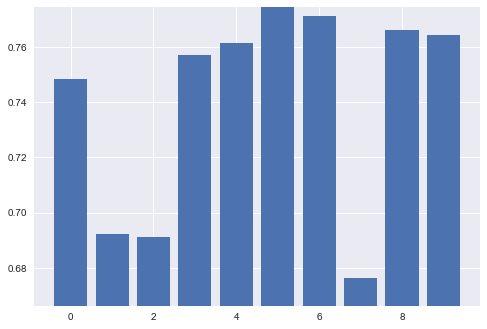

In [16]:
## This cell is bad pls fix, needs GridSearchCV -> FIXED

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
# from sklearn.model_selection import KFold -> use stratified said larson
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score
import warnings
warnings.filterwarnings('ignore')


# params = dict(n_hidden=50, 
#               C=0.1, # tradeoff L2 regularizer
#               epochs=200, # iterations
#               eta=0.001,  # learning rate
#               random_state=1)  # Todo make this use CustomTLP required params


params = {
#     'cost_function':('cross_entropy', 'quadratic'),
    'nonlinearity_function':('linear', 'sigmoid'),
    'n_hidden': [50],
    'C': [0.1],
    'epochs': [200],
    'eta': [0.001],
    'random_state': [1]
}

mlp = CustomTLP()

clf = Pipeline([('scl',StandardScaler()),
                ('clf',GridSearchCV(mlp, params))])  # use gridSearchCV here

my_scorer = make_scorer(custom_score) 
cv = StratifiedKFold(n_splits=10)
for train_index, test_index in cv.split(X,y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

per_fold_eval_criteria = cross_val_score(estimator=clf,
                                    X=X,
                                    y=y,
                                    cv=cv,
                                    scoring=my_scorer
                                   )

plt.bar(range(len(per_fold_eval_criteria)),per_fold_eval_criteria)
plt.ylim([min(per_fold_eval_criteria)-0.01,max(per_fold_eval_criteria)])

### Hyper-Parameter Tuning

While it will take up way to much time to hyper tune with every possible parameters, we chose from a range of values to find the best value for our parameters.

In [76]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline

params = {
    'cost_function':('cross_entropy','quadratic'),
    'nonlinearity_function':('linear', 'sigmoid'),
    'n_hidden': [50],
    'C': [0.01,0.1],
    'epochs': [200],
    'eta': [0.001, 0.01],
    'random_state': [1]
}
mlp = CustomTLP()
my_scorer = make_scorer(custom_score) 
clf = GridSearchCV(mlp, params, scoring=my_scorer, cv=cv)
clf.fit(X, y)
#put it in a df for formating
pd.DataFrame(clf.cv_results_)

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_C,param_cost_function,param_epochs,param_eta,param_n_hidden,param_nonlinearity_function,...,split7_test_score,split7_train_score,split8_test_score,split8_train_score,split9_test_score,split9_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,0.772204,0.000501,0.773931,0.773931,0.01,cross_entropy,200,0.001,50,linear,...,0.775510,0.773756,0.775510,0.773756,0.773973,0.773926,0.096555,5.228928e-07,0.002154,0.000240
1,0.951631,0.000451,0.542627,0.542467,0.01,cross_entropy,200,0.001,50,sigmoid,...,0.775510,0.773756,0.008772,0.007797,0.773973,0.773926,0.035568,2.701198e-04,0.353964,0.353432
2,0.728288,0.000401,0.463680,0.464329,0.01,cross_entropy,200,0.01,50,linear,...,0.000000,0.000000,0.775510,0.773756,0.773973,0.773926,0.040950,3.004659e-04,0.379560,0.379123
3,0.936491,0.000401,0.773931,0.773931,0.01,cross_entropy,200,0.01,50,sigmoid,...,0.775510,0.773756,0.775510,0.773756,0.773973,0.773926,0.061138,2.006414e-04,0.002154,0.000240
4,0.678204,0.000351,0.773931,0.773931,0.01,quadratic,200,0.001,50,linear,...,0.775510,0.773756,0.775510,0.773756,0.773973,0.773926,0.018728,2.298305e-04,0.002154,0.000240
5,0.984569,0.000552,0.696538,0.696555,0.01,quadratic,200,0.001,50,sigmoid,...,0.775510,0.773756,0.775510,0.773756,0.773973,0.773926,0.097845,1.502912e-04,0.231926,0.232185
6,0.729891,0.000451,0.465037,0.464353,0.01,quadratic,200,0.01,50,linear,...,0.775510,0.773756,0.000000,0.000000,0.000000,0.000000,0.064848,1.504584e-04,0.379061,0.379143
7,0.956093,0.000451,0.696538,0.696555,0.01,quadratic,200,0.01,50,sigmoid,...,0.775510,0.773756,0.775510,0.773756,0.773973,0.773926,0.051639,1.504424e-04,0.231926,0.232185
8,0.783885,0.000401,0.773931,0.773931,0.1,cross_entropy,200,0.001,50,linear,...,0.775510,0.773756,0.775510,0.773756,0.773973,0.773926,0.060289,2.005223e-04,0.002154,0.000240
9,0.964014,0.000401,0.386965,0.385583,0.1,cross_entropy,200,0.001,50,sigmoid,...,0.768707,0.760393,0.000000,0.000000,0.000000,0.000000,0.041731,2.005818e-04,0.386708,0.385602


So the best result we have has 77.39% of mean test score, and 0.678s for fit time. Tuned parameters are:

    Cost_Funtion: Quadratic
    Nonlinearity_Function : Relu
    C : 0.01
    eta : 0.001

### Compare Performance to Scikit-Learn

With our tuned values, now we will compare our model to SK Learn.

In [77]:
from sklearn.neural_network import MLPClassifier

#parameter for our MLP
params = {
    'cost_function':('quadratic'),
    'nonlinearity_function':('linear'),
    'n_hidden': [50],
    'C': [0.01],
    'epochs': [200],
    'eta': [0.001],
    'random_state': [1]
}

#sklearn
sk = MLPClassifier(hidden_layer_sizes=(50, ), 
                    activation='logistic', 
                    solver='sgd', 
                    alpha=1e-4, # L2 penalty
                    batch_size='auto', # min of 200, num_samples
                    learning_rate='constant', 
                    learning_rate_init=0.1, # only SGD
                    power_t=0.5,    # only SGD
                    max_iter=75, 
                    shuffle=True, 
                    random_state=1, 
                    tol=1e-9, # for stopping
                    verbose=False, 
                    warm_start=False, 
                    momentum=0.9, # only SGD
                    nesterovs_momentum=True, # only SGD
                    early_stopping=False, 
                    validation_fraction=0.1, # only if early_stop is true
                    beta_1=0.9, # adam decay rate of moment
                    beta_2=0.999, # adam decay rate of moment
                    epsilon=1e-08) # adam numerical stabilizer

our = CustomTLP()

In [78]:
%%time
sk.fit(X_train,y_train)

Wall time: 48.6 ms


MLPClassifier(activation='logistic', alpha=0.0001, batch_size='auto',
       beta_1=0.9, beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(50,), learning_rate='constant',
       learning_rate_init=0.1, max_iter=75, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=1, shuffle=True,
       solver='sgd', tol=1e-09, validation_fraction=0.1, verbose=False,
       warm_start=False)

In [79]:
yhat_sk=sk.predict(X_test)
print("SK Score: ", custom_score(y_test, yhat_sk))

SK Score:  0.773972602739726


In [82]:
%%time
our.fit(X_train,y_train)

Wall time: 1.68 s


In [81]:
yhat_our=our.predict(X_test)
print("Our Score:", custom_score(y_test, yhat_our))

Our Score: 0.773972602739726


With our custom scoring method, SK-Learn and custom MLP derives same socre. However the time it takes is approximately 35 times as long as SK_Learn's method.

## Exceptional Work

For Exceptional Work we tried to implement a selectible N-Layer MLP.

### N-Layer Perceptron

Building an N-Layer Perceptron would only require being able to select the number of layers. So we added in the variable and set it to 2 as default.

In [23]:
class MultiLayerPerceptronBase(object):
    def __init__(self, n_hidden=30,
                 C=0.0, epochs=500, eta=0.001, random_state=None, n_layers = 2):
        np.random.seed(random_state)
        self.n_hidden = n_hidden
        self.l2_C = C
        self.epochs = epochs
        self.eta = eta
        self.n_layers = n_layers
        
    @staticmethod
    def _encode_labels(y):
        """Encode labels into one-hot representation"""
        onehot = pd.get_dummies(y).values.T
            
        return onehot

    def _initialize_weights(self):
        """Initialize weights with small random numbers."""
        # suggested relu/sigmoid bounds
        #Xavier Glorot, Yoshua Bengio ; 
        #  Understanding the difficulty of training deep feedforward neural networks
        #  Conference on Artificial Intelligence and Statistics, PMLR 9:249-256, 2010.
        W = []
        init_bound = np.sqrt(6. / (self.n_hidden + self.n_features_ + 1))
        for ind in range(self.n_layers):
            W.append(np.random.uniform(-init_bound, init_bound,(self.n_hidden, self.n_features_ + 1)))
            W[ind][:,:1] = 0
        
        # reduce the final layer magnitude in order to balance the size of the gradients
        # between 
        init_bound = np.sqrt(0.5 / (self.n_output_ + self.n_hidden + 1))
        W.append(np.random.uniform(-init_bound, init_bound,(self.n_output_, self.n_hidden + 1)))
        W[len(W) - 1][:,:1] = 0
        
        return W
    
    @staticmethod
    def _sigmoid(z):
        """Use scipy.special.expit to avoid overflow"""
        # 1.0 / (1.0 + np.exp(-z))
        return expit(z)
    
    @staticmethod
    def _relu(Z):
        return np.maximum(0,Z.copy())        
    
    @staticmethod
    def _add_bias_unit(X, how='column'):
        """Add bias unit (column or row of 1s) to array at index 0"""
        if how == 'column':
            ones = np.ones((X.shape[0], 1))
            X_new = np.hstack((ones, X))
        elif how == 'row':
            ones = np.ones((1, X.shape[1]))
            X_new = np.vstack((ones, X))
        return X_new
    
    @staticmethod
    def _L2_reg(lambda_, W):
        total_means = 0
        for weight in self.W:
            total_means += np.mean(weight[:, 1:] ** 2)
        return(lambda_/len(self.W) * np.sqrt(total_means))
    
    def _cost(self, last_A, Y_enc, W):
        '''Get the objective function value'''
        cost = np.mean((Y_enc-last_A)**2)
        L2_term = self._L2_reg(self.l2_C, W)
        return cost + L2_term
    
    def _feedforward(self, X, W):
        A = []
        Z = [] 
        
        A.append(self.add_bias_unit(X, how = 'column'))
        Z.append(W[0] @ A[0].T)
        
        for index in range(1, len(W)):
            A.append(self._sigmoid(Z[index-1]))
            self.add_bias_unit(A[index], how = 'row')
            Z.append(W[index] @ A[index].T)
                                    
        A.append(self._sigmoid(Z[len(Z) - 1]))
        return A, Z
                                    
    def _get_gradient (self, A, Z, Y_enc, W):
        sigma=[]
                                    
        # Highest -> Lowest
        sigma.insert(0, (-2*(Y_enc - A[len(A) - 1])*A[len(A) - 1]*(1 - A(len[A] - 1))))
                                    
        # Go down the list of sigma
        for index in range(len(A)-2, 0, -1):
            sigma.insert(0, ((W[index].T @ sigma[0])*A[index]*(1-A[index])))
        
        gradient = []
        gradient.append(sigma[0][1:,:] @ A[0])
        # Go up the list of gradient
        for index in range(1, len(sigma)):
            gradient.append(sigma[index] @ A[index].T)
                                    
        # Regularize weights that are not bias terms
        for index in range(len(gradient)):
            gradient[index][:, 1:] += W[index][:, 1:] * self.L2_C
                                    
        return gradient
    
    def predict(self, X):
        """Predict class labels"""
        A, _ = self._feedforward(X, self.W)
        y_pred = np.argmax(A[len(A)-1], axis=0)
        return y_pred

In [30]:
class MLPMiniBatch(MultiLayerPerceptronBase):
    def __init__(self, alpha=0.0, decrease_const=0.0, shuffle=True, 
                 minibatches=1, **kwds):        
        # need to add to the original initializer 
        self.alpha = alpha
        self.decrease_const = decrease_const
        self.shuffle = shuffle
        self.minibatches = minibatches
        # but keep other keywords
        super().__init__(**kwds)
        
    
    def fit(self, X, y, print_progress=False):
        """ Learn weights from training data. With mini-batch"""
        X_data, y_data = X.copy(), y.copy()
        Y_enc = self._encode_labels(y)
        
        # init weights and setup matrices
        self.n_features_ = X_data.shape[1]
        self.n_output_ = Y_enc.shape[0]
        self.W = self._initialize_weights()

        delta_W_prev = []
        for weights in self.W:
            delta_W_prev.append(np.zeros(weights.shape))

        self.cost_ = []
        self.score_ = []
        for i in range(self.epochs):

            # adaptive learning rate
            self.eta /= (1 + self.decrease_const*i)

            if print_progress>0 and (i+1)%print_progress==0:
                sys.stderr.write('\rEpoch: %d/%d' % (i+1, self.epochs))
                sys.stderr.flush()

            if self.shuffle:
                idx_shuffle = np.random.permutation(y_data.shape[0])
                X_data, Y_enc, y_data = X_data[idx_shuffle], Y_enc[:, idx_shuffle], y_data[idx_shuffle]

            mini = np.array_split(range(y_data.shape[0]), self.minibatches)
            mini_cost = []
            for idx in mini:

                # feedforward
                A, Z = self._feedforward(X_data[idx],
                                         self.W)
                
                cost = self._cost(A[len(A)-1],Y_enc[:, idx],self.W)
                mini_cost.append(cost) # this appends cost of mini-batch only

                # compute gradient via backpropagation
                grad = self._get_gradient(A, Z, Y_enc[:, idx], self.W)

                # momentum calculations
                delta_W = self.eta * grad
                for index in range(len(self.W)):
                    self.W[index] -= (delta_W[index] + (self.alpha * delta_W_prev[index]))
                delta_W_prev = delta_W

            self.cost_.append(mini_cost)
            self.score_.append(custom_score(y_data,self.predict(X_data)))
            
        return self

In [99]:
class CustomMLP(MLPMiniBatch):
    def __init__(self, nonlinearity_function="sigmoid", cost_function="quadratic", **kwargs):
        self.nonlinearity_function = nonlinearity_function
        self.cost_function = cost_function
        super().__init__(**kwargs)
        
    def _quad_cost(self, last_A, Y_enc, W):
        '''Get the objective function value'''
        cost = np.mean((Y_enc-last_A)**2)
        L2_term = self._L2_reg(self.l2_C, W)
        return cost + L2_term
    
    def _cross_entropy_cost(self, last_A, Y_enc, W):
        cost = -np.mean(np.nan_to_num((Y_enc*np.log(last_A)+(1-Y_enc)*np.log(1-last_A))))
        L2_term = self._L2_reg(self.l2_C, W)
        return cost + L2_term
    
    def _cost(self, last_A, Y_enc, W):
        if self.cost_function == "quadratic":
            return self._quad_cost(last_A, Y_enc, W)
        elif cost_function == "cross_entropy":
            return self._cross_entropy_cost(last_A, Y_enc, W)
        else:
            raise Exception("Use 'quadratic'/'cross_entropy' for the value of cost_function")
    
    def _get_gradient(self, A, Z, Y_enc, W):
        if self.nonlinearity_function == "linear":
            return self._linear_gradient(A, Z, Y_enc, W)
        else:
            return self._sigmoid_gradient(A, Z, Y_enc, W)
        
    
    def _sigmoid_gradient(self, A, Z, Y_enc, W):
        sigma=[]
                                    
        # Highest -> Lowest
        sigma.insert(0, (-2*(Y_enc - A[len(A) - 1])*A[len(A) - 1]*(1 - A(len[A] - 1))))
                                    
        # Go down the list of sigma
        for index in range(len(A)-2, 0, -1):
            sigma.insert(0, ((W[index].T @ sigma[0])*A[index]*(1-A[index])))
        
        gradient = []
        gradient.append(sigma[0][1:,:] @ A[0])
        # Go up the list of gradient
        for index in range(1, len(sigma)):
            gradient.append(sigma[index] @ A[index].T)
                                    
        # Regularize weights that are not bias terms
        for index in range(len(gradient)):
            gradient[index][:, 1:] += W[index][:, 1:] * self.L2_C
                                    
        return gradient
    
    def _linear_gradient(self, A, Z, Y_enc, W):
        sigma=[]
                                    
        # Highest -> Lowest
        sigma.insert(0, (Y_enc - A[len(A) - 1]))
                                    
        # Go down the list of sigma
        for index in range(len(A)-2, 0, -1):
            sigma.insert(0, (W[index].T @ sigma[0]))
        
        gradient = []
        gradient.append(sigma[0][1:,:] @ A[0])
        # Go up the list of gradient
        Z_counter = 0
        for index in range(1, len(sigma)):
            gradient.append(sigma[index] @ A[index].T)
            Z_with_bias = self._add_bias_unit(Z[Z_counter],how='row')
            Z_counter += 1
            sigma[0][Z_with_bias<=0] = 0
                                    
        # Regularize weights that are not bias terms
        gradient[0] = sigma[0][1:,:] @ A[0]
        for index in range(1, len(gradient)):
            gradient[index] = sigma[index] @ A[index].T
                                    
        return gradient
    
    def _feedforward(self, X, W):
        """Compute feedforward step
        """
        A = []
        Z = [] 
        
        A.append(self._add_bias_unit(X, how = 'column'))
        Z.append(W[0] @ A[0].T)
        
        for index in range(1, len(W)):
            if self.nonlinearity_function == "linear":
                A.append(self._relu(Z[index-1]))
            else:
                A.append(self._sigmoid(Z[index-1]))
            self._add_bias_unit(A[index], how = 'row')
            Z.append(W[index].reshape(9,30) @ A[index])
                                    
        A.append(self._sigmoid(Z[len(Z) - 1]))
        return A, Z
    
    ## The following params are to enable compatibility with GridSearchCV
    def get_params(self, deep=True):
        return {"cost_function": self.cost_function, 
                "nonlinearity_function": self.nonlinearity_function, 
                "C": self.l2_C, 
                "epochs": self.epochs, 
                "eta": self.eta, 
                "n_hidden": self.n_hidden,
                "n_layers": self.n_layers
               }
    
    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            self.__setattr__(parameter, value)
            
        return self
    
    def score(self, X, y):
        y_hat = self.predict(X)
        return custom_score(y, y_hat)  # Using our custom score metric

While running the mlp to compare its performance to the TLP and SK_Learn, we faced reshape error with dimensionality.

In [100]:
mlp = CustomMLP()

In [101]:
mlp.fit(X, y)

ValueError: total size of new array must be unchanged

We tried Transposing and resizing the array in order to fix the issue, however we were unsuccesful in this attemp. 

In theory, we predicted that increasing the layers would have pros and cons that's easily observed from the code. While its possible to improving prediction performance, we also noticed that calculating gradient could increase the error as the number of layer increases.

### Note

Another python problem we had during comparison was using %memit for comparing usage of peak memory. After 1, downloading and 2, loading the memory_profiler, we still could not get this to work due to runtime error which we could not fix.

In [105]:
%load_ext memory_profiler

The memory_profiler extension is already loaded. To reload it, use:
  %reload_ext memory_profiler
